# Recurrent Neural Network #

RNN are useful for processing sequential data, such as language and time series, in which the next output is often based on multiple inputs that came before it. For example, when filling in the next word in a sentence, the logical solutions are very much dependent on the words that came previously in the sentence.

The RNN works by having a hidden layer that remembers some previous inputs and can use them in making future predictions. The RNN structure appears as follows:

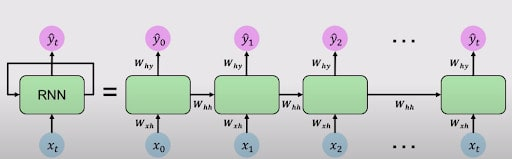

The left part of the image is the recurrent network, and the right shows how the network sequentially processes. For example, take X to be a sentence. Then $x_{t-1}$ is a word to be processed, $x_t$ is another word to be processed, etc. Each of the time stamps shown share the same weight matrix.

## Long Short-Term Memory (LSTM) ##

The LSTM cell adds gates to the RNN architecture to help address the vanishing and exploding gradient problems. An LSTM cell has an input gate, and output gate, and a forget gate to control the flow of information. Forget gates can decide information from a previous state is not useful and discard it, while input and output gates determine waht information to store and return respectively.

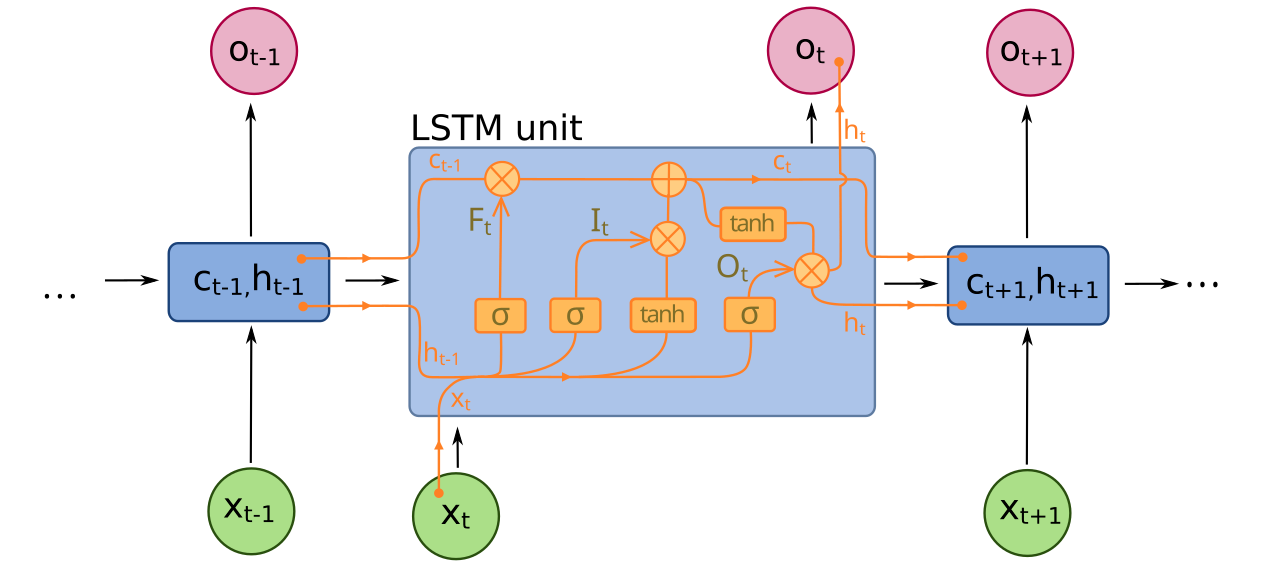

## RNN with LSTM Implementation ##

This implmentation will demonstrate a simple RNN with LSTM model for time series prediction. As a toy example, it will use a sine wave as shown in this [Kaggle](https://www.kaggle.com/code/namanmanchanda/rnn-in-pytorch) example.

### Set up Data Set ###

First, data for the sine wave is created by making the wave and the X-values to be time steps. Then, the data must be split into a training and testing set. This will be accomplished by setting aside the last 40 time steps of the data as a testing set.

Finally, the data needs to be prepared for working with the RNN. This will be accomplished by creating subsequences of the data set, which create sliding windows of time steps. If the time step is 3, then we would have a subsequence be (t=1, t=2, t=3) and another be (t=2, t=3, t=4), etc.

In [1]:
import torch

# create the sine wave data
X = torch.linspace(0, 799, 800)
Y = torch.sin(X*2*3.14/40)

# create training and testing subsets
train_data = Y[:759]
test_data = Y[759:]

# batch data
def batch_data(data):
    output = []
    L = len(data)
    
    for i in range(L-10):
        x = data[i:i+10]
        y = data[i+10:i+11]
        output.append((x, y))
    
    return output

### Create the Model ###

Create an RNN with LSTM model for predicting the sine wave. The model will have one LSTM cell, followed by a fully connected layer producing the final output.

In [2]:
from torch import nn
from torch.autograd import Variable

class RNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
        self.linear = nn.Linear(in_features=50, out_features=1)
    
    def forward(self, X):
        # initialize the hidden state and cell state
        # should be size: (D*num_layers, N, H_out) and (D*num_layers, N, H_cell) respectively     
        h0 = (torch.zeros(1, X.shape[0], 50), torch.zeros(1, X.shape[0], 50))
        
        # input is [32, 10], want it to be [batch size, sequence length, hidden state in]
        X = X.unsqueeze(2)
        
        output,h1 = self.lstm(X, h0)
        output = self.linear(output)
        # shape: N, L, H_in
        output = output[:,-1,:]
                    
        return output

### Train and Test the Model ###

The model is trained over 5 epochs and then tested on the testing set. For training, the Adam optimizer and mean squared error loss is used. Mini-batches of size 32 are used for training.

In [9]:
from torch import optim
import torch
from torch.utils.data import DataLoader

if __name__ == '__main__':
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # get training and testing data
    train = batch_data(train_data)
    test = batch_data(test_data)
    
    train_loader = DataLoader(train, batch_size=32)
    test_loader = DataLoader(test, batch_size=len(test))
        
    # prepare model
    model = RNN_LSTM()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    
    # train the model
    for e in range(5):
        model.train()
        total_loss = 0
        
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
                                    
            pred = model(x)        
            loss = loss_fn(pred, y)
            total_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print('Epoch: {0}'.format(e))
        print('----Loss: {0:.2f}'.format(total_loss))
    
    # test the model
    with torch.no_grad():
        model.eval()
        for x,y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            pred = model(x)
            loss = loss_fn(pred, y)
            
            print('--------------------------------------------------')
            print('Test Loss: {0:.2f}'.format(loss))
        

Epoch: 0
----Loss: 10.50
Epoch: 1
----Loss: 6.06
Epoch: 2
----Loss: 3.46
Epoch: 3
----Loss: 0.55
Epoch: 4
----Loss: 0.05
--------------------------------------------------
Test Loss: 0.00
